
# Classification Problem: Rent

In [19]:
! pip install pyspark seaborn

In [20]:
#libraries

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LinearSVC, OneVsRest, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.sql.functions as F

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/Colab Notebooks/Project/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
spark = SparkSession.builder.appName("Project511_ML_RENT").master("local[*]").config("spark.driver.maxResultSize", "2g").getOrCreate()

# Read Dataset

In [23]:
#Read dataset which was preprocessed and the text was converted to numerical representation
rent_df = spark.read.format("parquet").load(google_drive_path + "rent_tfidf.parquet")

In [24]:
rent_df.show()

+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|start_date|  end_date|                  l2|                l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|operation_type|         coordinates|    amount_in_euro|    full_description|      processed_text|             bigrams|            trigrams|   features_unigrams|    features_bigrams|   features_trigrams|            features|      final_features|
+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+------------------+--------------------+--------------------+-----------------

In [25]:
rent_df.count()

49569

We drop multiple columns created by the text analytics process and keep only the 'final_feature' column, which represents the numerical essence of the text data.

In [26]:
rent_df = rent_df.drop("full_description", "processed_text", "bigrams", "trigrams", "features_unigrams", "features_bigrams", "features_trigrams", "features")

# Create Buckets

In [27]:
# casting amount to euro to integer (round to the nearest integer)
rent_df = rent_df.withColumn("amount_in_euro", round("amount_in_euro", 2))

In [28]:
rent_df.select("amount_in_euro").agg(min("amount_in_euro"), max("amount_in_euro"), avg("amount_in_euro")).show()

+-------------------+-------------------+-------------------+
|min(amount_in_euro)|max(amount_in_euro)|avg(amount_in_euro)|
+-------------------+-------------------+-------------------+
|               14.3|           210680.0| 1084.4188182130033|
+-------------------+-------------------+-------------------+



 We checked the range of our price values by calculating the minimum, maximum, and average values of the 'amount_in_euro', revealing a range from 14.3 to 210,680 euros, with an average of approximately 1084.42 euros. To better handle very high or low prices and make the data more suitable for analysis, we decided to take the logarithm of the price column.

In [29]:
rent_df = rent_df.withColumn("log_price", log(col("amount_in_euro")))

After taking the logarithm, we divided the prices into several meaningful buckets based on their logarithmic values. Using the defined function 'define_price_bucket', we assigned each price into one of five buckets: prices up to 190 euros were categorized into bucket 0, those between 190 and 300 euros into bucket 1, those between 300 and 570 euros into bucket 2, those between 570 and 2000 euros into bucket 3, and any higher prices into bucket 4. This categorization allows for a more manageable representation of price ranges in our analysis, aiding in tasks such as visualization and modeling.

In [30]:
rent_df.filter(col("amount_in_euro") <= 190).count()

13375

In [31]:
rent_df.filter((col("amount_in_euro") > 190) & (col("amount_in_euro") <= 300)).count()

12251

In [32]:
rent_df.filter((col("amount_in_euro") > 300) & (col("amount_in_euro") <= 570)).count()

10476

In [33]:
rent_df.filter((col("amount_in_euro") > 570) & (col("amount_in_euro") <= 2000)).count()

8495

In [34]:
from pyspark.sql.functions import when, col

def define_price_bucket(amount):
    return (when(col(amount) <= 190, 0)
            .when((col(amount) > 190) & (col(amount) <= 300), 1)
            .when((col(amount) > 300) & (col(amount) <= 570), 2)
            .when((col(amount) > 570) & (col(amount) <= 2000), 3)
            .otherwise(4))

# Apply the function to create the 'price_bucket' column
rent_df = rent_df.withColumn("price_bucket", define_price_bucket("amount_in_euro"))


In [115]:
rent_df.groupBy("price_bucket").count().show() # displaying the buckets

+------------+-----+
|price_bucket|count|
+------------+-----+
|           1|12251|
|           3| 8495|
|           4| 4972|
|           2|10476|
|           0|13375|
+------------+-----+



<ipython-input-119-08c6bbbe5108>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bucket_counts, x='price_bucket', y='count', palette="viridis")


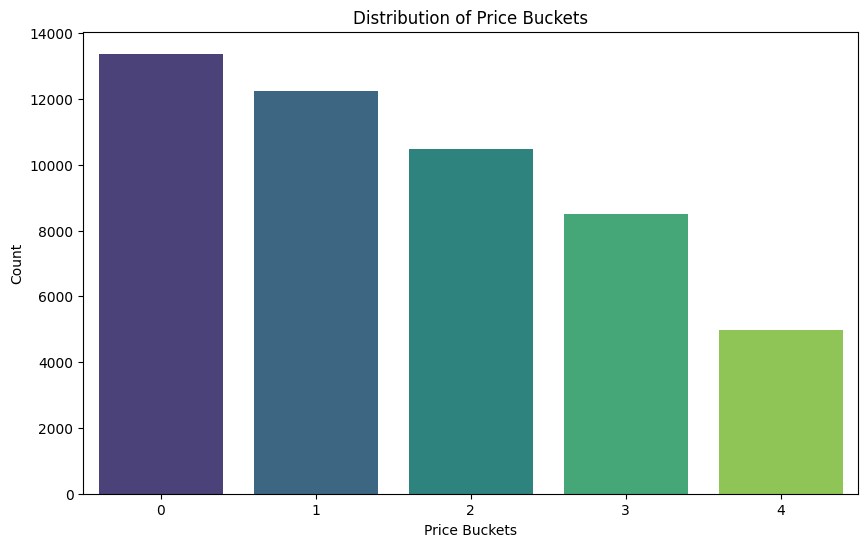

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for plotting
bucket_counts = rent_df.groupBy("price_bucket").count().toPandas()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=bucket_counts, x='price_bucket', y='count', palette="viridis")
plt.title('Distribution of Price Buckets')
plt.xlabel('Price Buckets')
plt.ylabel('Count')
plt.xticks()
plt.show()


The bar plot displays the five price buckets we created. We can clearly see that the distribution across the columns is imbalanced, with the values of some groups being significantly higher than others. For example, Group 1 (represented as 0 in the plot) is almost double that of Group 5 (represented as 4 in the plot).

Moving forward, we grouped the dataset by the 'price_bucket'  columns and counts the occurrences of each combination. Afterward, it orders the results by 'price_bucket' and the count of occurrences in descending order for better readability. Finally, it displays the top 50 results showing the counts of each property type within each price buckets.

In [37]:
# Group by 'price_bucket' and 'property_type' and count occurrences
type_bucket_counts = rent_df.groupBy("price_bucket", "property_type").count()

# Order by 'price_bucket' for better readability
type_bucket_counts = type_bucket_counts.orderBy("price_bucket", "count", ascending=False)

# Show the results
type_bucket_counts.show(50)

+------------+----------------+-----+
|price_bucket|   property_type|count|
+------------+----------------+-----+
|           4|       Apartment| 1097|
|           4|           House| 1061|
|           4|          Office| 1004|
|           4|Commercial Space|  702|
|           4|           Other|  674|
|           4|       Warehouse|  319|
|           4|             Lot|   70|
|           4|          Garage|   26|
|           4|          Duplex|   15|
|           4|   Country House|    4|
|           3|       Apartment| 2242|
|           3|           House| 1701|
|           3|           Other| 1537|
|           3|Commercial Space| 1494|
|           3|          Office|  892|
|           3|       Warehouse|  355|
|           3|          Duplex|  137|
|           3|             Lot|  101|
|           3|   Country House|   21|
|           3|          Garage|   15|
|           2|       Apartment| 5076|
|           2|           House| 1561|
|           2|Commercial Space| 1158|
|           

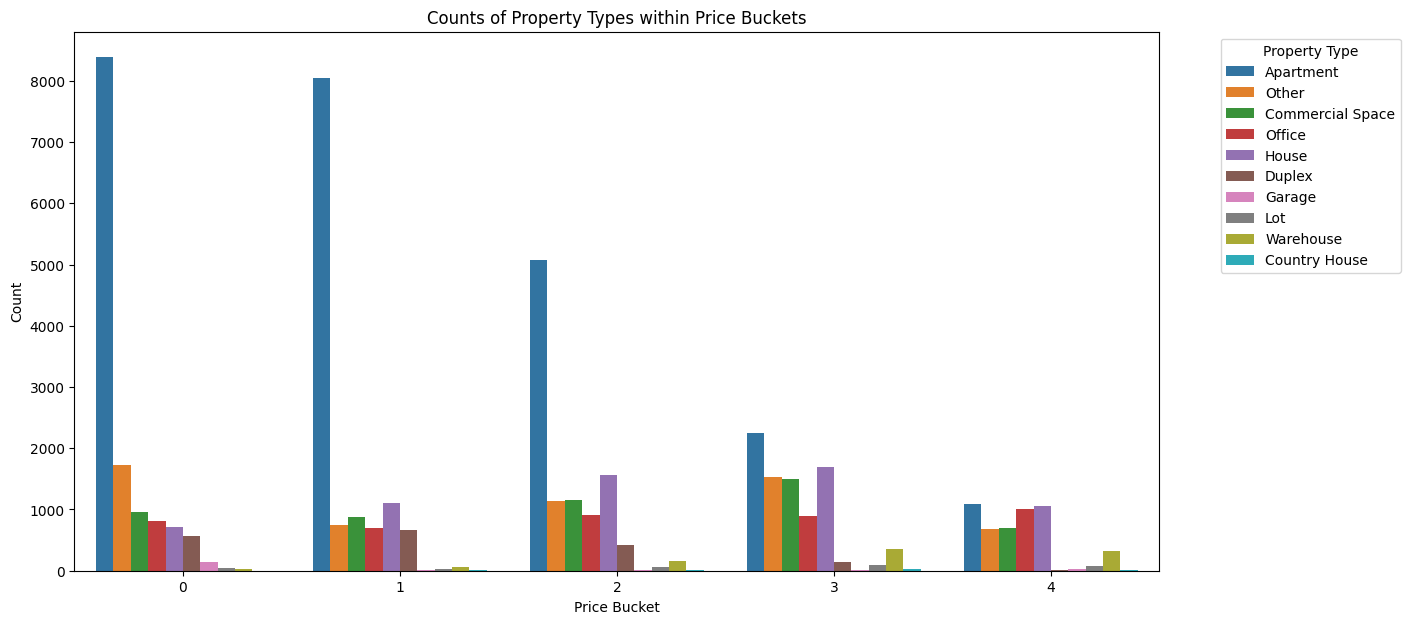

In [38]:
# Convert to Pandas DataFrame for plotting
type_bucket_counts_pd = type_bucket_counts.toPandas()

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x="price_bucket", y="count", hue="property_type", data=type_bucket_counts_pd)
plt.title('Counts of Property Types within Price Buckets')
plt.xlabel('Price Bucket')
plt.ylabel('Count')
plt.xticks()
plt.legend(title='Property Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



Barplot insights:
* Apartments are the most common property type across most price buckets, particularly dominant in price buckets 0 and 1.
* Houses and Commercial Spaces also appear frequently, but less so than apartments, and are more evenly distributed across the price buckets.
* Other property types like offices, duplexes, garages, lots, warehouses, and country houses are less frequent overall and show smaller counts in the various price buckets.



# Encoding

## Operation Type

Operation type column now have only one value: rent. So we dropped out the column.

In [39]:
rent_df = rent_df.drop("operation_type")

## Start Date and End Date

We extracted year, month, and day of the week from the "start_date" and "end_date" columns

In [40]:

rent_df = rent_df.withColumn("start_year", year("start_date")) \
                 .withColumn("start_month", month("start_date")) \
                 .withColumn("start_day_of_week", dayofweek("start_date"))



In [41]:
rent_df = rent_df.withColumn("end_year", year("end_date")) \
                 .withColumn("end_month", month("end_date")) \
                 .withColumn("end_day_of_week", dayofweek("end_date"))

In [42]:
rent_df = rent_df.withColumn("is_active", F.when(col("end_year") == 9999, 1).otherwise(0))

In [43]:
rent_df = rent_df.withColumn("end_year", F.when(col("end_year") == 9999, 2021).otherwise(col("end_year")))

In [44]:
rent_df.show()

+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+
|start_date|  end_date|                  l2|                l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|         coordinates|amount_in_euro|      final_features|         log_price|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|
+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+
|2020-11-02|2020-11-16|     Capital Federal|           Palermo|    2|       

In [45]:
#drop the "start_data" and "end_data"
rent_df = rent_df.drop("start_date", "end_date")

## l3

WFirst, we find less common categories in the 'l3' column—those appearing 2100 times or fewer. We group these as 'Other' to focus on the most common ones. Then, we check how many unique categories are left in the 'l3' column. Next, we convert the 'l3' column into numbers using StringIndexer and OneHotEncoder.

In [46]:
rent_df.select("l3").distinct().count()

385

In [47]:
# Count the frequency of each category in 'l3'
freq = rent_df.groupBy('l3').count()

# Filter to find categories that appear less than or equal to 10 times
infrequent_categories = freq.filter(col('count') <= 2100)


In [48]:
# Create a list or DataFrame of infrequent categories
infrequent_list = infrequent_categories.select('l3').rdd.flatMap(lambda x: x).collect()

# Broadcast the infrequent list to optimize join performance
infrequent_broadcast = spark.sparkContext.broadcast(infrequent_list)

# Create a new column where infrequent categories are replaced by 'Other'
rent_df = rent_df.withColumn('l3', when(col('l3').isin(infrequent_broadcast.value), 'Other').otherwise(col('l3')))


In [49]:
rent_df.select("l3").distinct().count()

5

In [50]:
# Indexing the modified 'l3' column
indexer_l3 = StringIndexer(inputCol="l3", outputCol="l3_encoded")

# One-hot encoding the indexed values
encoder_l3 = OneHotEncoder(inputCols=["l3_encoded"], outputCols=["l3_one_hot"])


In [51]:
# Define a pipeline to apply the transformations
pipeline_l3 = Pipeline(stages=[indexer_l3, encoder_l3])

In [52]:
# Fit and transform the DataFrame
rent_df = pipeline_l3.fit(rent_df).transform(rent_df)

In [53]:
# Now you can use 'transformed_df' for your machine learning purposes
rent_df.show()

+--------------------+-------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+----------+-------------+
|                  l2|           l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|         coordinates|amount_in_euro|      final_features|         log_price|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|l3_encoded|   l3_one_hot|
+--------------------+-------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+----------+-------------+
|     Capital Federal|      Palermo|    2|       2|        1|       2189.0|       

In [54]:
rent_df = rent_df.drop("l3_encoded", "l3")

## l2

Similarly, we begin by identifying infrequent categories in the 'l2' column, replacing them with a label 'Other' to prevent overfitting. Next, we encode the modified 'l2' column into numerical format, employing StringIndexer for indexing and OneHotEncoder for one-hot encoding. Finally, we apply these transformations using a pipeline.

In [55]:
# Indexing the modified 'l2' column
indexer_l2 = StringIndexer(inputCol="l2", outputCol="l2_encoded")

# One-hot encoding the indexed values
encoder_l2 = OneHotEncoder(inputCols=["l2_encoded"], outputCols=["l2_one_hot"])


In [56]:
# Define a pipeline to apply the transformations
pipeline_l2 = Pipeline(stages=[indexer_l2, encoder_l2])

In [57]:
# Fit and transform the DataFrame
rent_df = pipeline_l2.fit(rent_df).transform(rent_df)

In [58]:
rent_df.show()

+--------------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+----------+--------------+
|                  l2|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|         coordinates|amount_in_euro|      final_features|         log_price|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|   l3_one_hot|l2_encoded|    l2_one_hot|
+--------------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+----------+--------------+
|     Capital Federal|    2|       2|        1|       2189.0|         1813.0|  

In [59]:
rent_df = rent_df.drop("l2", "l2_encoded")

In [60]:
rent_df.show()

+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+--------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|         coordinates|amount_in_euro|      final_features|         log_price|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|   l3_one_hot|    l2_one_hot|
+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+--------------+
|    2|       2|        1|       2189.0|         1813.0|        Other|[-34.581897735595...|       21385.0|(17000,[0,1,5,6,9...| 9.970445020661009|           4|      2020|     

## Property type

Moving forward, we indexex the categories in the 'property_type' column, then applies one-hot encoding to create binary vectors for each category. Afterward, it drops the original 'property_type' column as it's replaced by the encoded vectors, simplifying the dataset for further analysis or modeling.

In [61]:
# Indexing the modified 'property_type' column
indexer_property = StringIndexer(inputCol="property_type", outputCol="property_encoded")

# One-hot encoding the indexed values
encoder_property = OneHotEncoder(inputCols=["property_encoded"], outputCols=["property_one_hot"])

In [62]:
# Define a pipeline to apply the transformations
pipeline_property = Pipeline(stages=[indexer_property, encoder_property])

In [63]:
# Fit and transform the DataFrame
rent_df = pipeline_property.fit(rent_df).transform(rent_df)

In [64]:
rent_df = rent_df.drop("property_type", "property_encoded")

In [65]:
rent_df.show()

+-----+--------+---------+-------------+---------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+--------------+----------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|         coordinates|amount_in_euro|      final_features|         log_price|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|
+-----+--------+---------+-------------+---------------+--------------------+--------------+--------------------+------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+--------------+----------------+
|    2|       2|        1|       2189.0|         1813.0|[-34.581897735595...|       21385.0|(17000,[0,1,5,6,9...| 9.970445020661009|           4|      2020|         1

## Dates (Month and Day of Week)

We used StringIndexer to convert categorical values in columns such as 'start_month', 'end_month', 'start_day_of_week', and 'end_day_of_week' into numerical indices. Subsequently, OneHotEncoder is applied to these indexed values, creating binary vectors in new columns like 'encoded_start_month', 'encoded_end_month', 'encoded_start_day_of_week', and 'encoded_end_day_of_week'.

In [66]:
indexer_date = StringIndexer(inputCols=["start_month", "end_month", "start_day_of_week", "end_day_of_week"],
                              outputCols=["indexed_start_month", "indexed_end_month", "indexed_start_day_of_week", \
                                          "indexed_end_day_of_week"])

# One-hot encoding the indexed month and day columns
encoder_date = OneHotEncoder(inputCols=["indexed_start_month", "indexed_end_month", "indexed_start_day_of_week", \
                                        "indexed_end_day_of_week"],
                        outputCols=["encoded_start_month", "encoded_end_month", "encoded_start_day_of_week", \
                                    "encoded_end_day_of_week"])

In [67]:
# Define a pipeline
pipeline_date = Pipeline(stages=[indexer_date, encoder_date])

In [68]:
# Fit the pipeline to the DataFrame
model_date = pipeline_date.fit(rent_df)

# Transform the DataFrame
rent_df = model_date.transform(rent_df)

In [69]:
rent_df = rent_df.drop("indexed_start_month", "indexed_end_month", "indexed_start_day_of_week", "indexed_end_day_of_week",
                       "start_month", "start_day_of_week", "end_month", "end_day_of_week")

In [70]:
rent_df.show()

+-----+--------+---------+-------------+---------------+--------------------+--------------+--------------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|         coordinates|amount_in_euro|      final_features|         log_price|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|
+-----+--------+---------+-------------+---------------+--------------------+--------------+--------------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+
|    2|       2|        1|       2189.0|         1813.0|[-34.581897735

# Scaling
Scaling is important for machine learning to ensure that features with different scales contribute equally to the model training process, preventing certain features from dominating due to their larger magnitude

## Lat Lon

In [71]:
rent_df.dtypes

[('rooms', 'int'),
 ('bedrooms', 'int'),
 ('bathrooms', 'int'),
 ('surface_total', 'double'),
 ('surface_covered', 'double'),
 ('coordinates', 'array<double>'),
 ('amount_in_euro', 'double'),
 ('final_features', 'vector'),
 ('log_price', 'double'),
 ('price_bucket', 'int'),
 ('start_year', 'int'),
 ('end_year', 'int'),
 ('is_active', 'int'),
 ('l3_one_hot', 'vector'),
 ('l2_one_hot', 'vector'),
 ('property_one_hot', 'vector'),
 ('encoded_start_month', 'vector'),
 ('encoded_end_month', 'vector'),
 ('encoded_start_day_of_week', 'vector'),
 ('encoded_end_day_of_week', 'vector')]

In [72]:
rent_df.dtypes

[('rooms', 'int'),
 ('bedrooms', 'int'),
 ('bathrooms', 'int'),
 ('surface_total', 'double'),
 ('surface_covered', 'double'),
 ('coordinates', 'array<double>'),
 ('amount_in_euro', 'double'),
 ('final_features', 'vector'),
 ('log_price', 'double'),
 ('price_bucket', 'int'),
 ('start_year', 'int'),
 ('end_year', 'int'),
 ('is_active', 'int'),
 ('l3_one_hot', 'vector'),
 ('l2_one_hot', 'vector'),
 ('property_one_hot', 'vector'),
 ('encoded_start_month', 'vector'),
 ('encoded_end_month', 'vector'),
 ('encoded_start_day_of_week', 'vector'),
 ('encoded_end_day_of_week', 'vector')]


We splitted the longitude and latitude, which are in list form, into two separate columns instead of a single list, to make them compatible with machine learning algorithms.

In [73]:
rent_df = rent_df.withColumn("latitude", col("coordinates").getItem(0))
rent_df = rent_df.withColumn("longitude", col("coordinates").getItem(1))

We applied MinMax scaling to normalize the latitude and longitude features. This was done to ensure that these features were on a similar scale to the other features in the dataset, making them comparable in magnitude.  
By dropping the original "coordinates" column, combining latitude and longitude into a single feature vector using VectorAssembler, and then scaling this vector with MinMaxScaler, we achieved normalization. These steps ensured that geographical coordinates were on a similar scale as other features, enabling fair comparison and accurate analysis within our dataset.

In [74]:
rent_df = rent_df.drop("coordinates")

In [75]:
# Define the VectorAssembler to combine latitude and longitude into a single feature vector
assembler_coord = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="coordinates_vector")

# Define the scaler
scaler_coord = MinMaxScaler(inputCol="coordinates_vector", outputCol="scaled_coordinates")

In [76]:
print(rent_df.columns)


['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'amount_in_euro', 'final_features', 'log_price', 'price_bucket', 'start_year', 'end_year', 'is_active', 'l3_one_hot', 'l2_one_hot', 'property_one_hot', 'encoded_start_month', 'encoded_end_month', 'encoded_start_day_of_week', 'encoded_end_day_of_week', 'latitude', 'longitude']


In [77]:
# Create a pipeline and fit it
pipeline_coord = Pipeline(stages=[assembler_coord, scaler_coord])
model_coord = pipeline_coord.fit(rent_df)
rent_df = model_coord.transform(rent_df)

In [78]:
rent_df.show()

+-----+--------+---------+-------------+---------------+--------------+--------------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-------------------+-------------------+--------------------+--------------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|amount_in_euro|      final_features|         log_price|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|           latitude|          longitude|  coordinates_vector|  scaled_coordinates|
+-----+--------+---------+-------------+---------------+--------------+--------------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+--------------------

In [79]:
rent_df = rent_df.drop("latitude", "longitude", "coordinates_vector")

We utilized the K-means clustering algorithm to cluster geographic locations. This algorithm partitioned the geographical coordinates into clusters based on their proximity, allowing us to categorize locations into groups with similar latitudes and longitudes.

In [80]:
kmeans = KMeans(featuresCol='scaled_coordinates', predictionCol='geo_cluster', k=10)
model_kmeans = kmeans.fit(rent_df)
rent_df = model_kmeans.transform(rent_df)


In [81]:
rent_df.show()

+-----+--------+---------+-------------+---------------+--------------+--------------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+--------------------+-----------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|amount_in_euro|      final_features|         log_price|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|  scaled_coordinates|geo_cluster|
+-----+--------+---------+-------------+---------------+--------------+--------------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+--------------------+-----------+
|    2|       2|        1|       2

In [82]:
rent_df = rent_df.drop("scaled_coordinates")

## Final Features

We applied a MinMaxScaler to the 'final_features' column which is a numeric vector representation of our text column, creating a scaled version in the new column 'scaled_final_features', and then removed the original 'final_features' column.

In [83]:
minmax_scaler = MinMaxScaler(inputCol="final_features", outputCol="scaled_final_features")

minmax_scaler_model = minmax_scaler.fit(rent_df)

rent_df = minmax_scaler_model.transform(rent_df)

In [84]:
rent_df = rent_df.drop("final_features")

In [85]:
rent_df.show()

+-----+--------+---------+-------------+---------------+--------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+---------------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|amount_in_euro|         log_price|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|geo_cluster|scaled_final_features|
+-----+--------+---------+-------------+---------------+--------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+---------------------+
|    2|       2|        1|       2189.0|         1813.0|       21385.0| 9.970445020661009|    

## Other Columns

We first assemble the selected numerical features ("rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered") into a single vector column named "features" using VectorAssembler. Then, we scale these features using MinMaxScaler to ensure that all features are within the same scale range.


In [86]:
assembler_other = VectorAssembler(
    inputCols=["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"],
    outputCol="features")

In [87]:
scaler_other = MinMaxScaler(
    inputCol="features",
    outputCol="scaled_features")

In [88]:
pipeline_other = Pipeline(stages=[assembler_other, scaler_other])

# Fit the pipeline to the DataFrame
model_other = pipeline_other.fit(rent_df)

# Transform the DataFrame
rent_df = model_other.transform(rent_df)

To handle the scaled features, we convert the vector representation into a list format using a function (UDF) named "split_array_to_list". This allows for easier manipulation and compatibility with subsequent processing steps.

Afterwards, we extract each scaled feature from the list representation and create separate columns for them, appending "_scaled" to the original feature name (e.g., "rooms_scaled", "bedrooms_scaled", etc.) make scaled feature easily accessible for analysis and modeling tasks.

In [89]:
def split_array_to_list(col):
    def to_list(v):
        return v.toArray().tolist()
    return F.udf(to_list, ArrayType(DoubleType()))(col)


In [90]:
rent_df = rent_df.withColumn("scaled_features", split_array_to_list(F.col("scaled_features")))

In [91]:
for i, feature in enumerate(["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]):
    rent_df = rent_df.withColumn(f"{feature}_scaled", col("scaled_features")[i])

In [92]:
rent_df.show()

+-----+--------+---------+-------------+---------------+--------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+---------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+----------------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|amount_in_euro|         log_price|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|geo_cluster|scaled_final_features|            features|     scaled_features|        rooms_scaled|    bedrooms_scaled|   bathrooms_scaled|surface_total_scaled|surface_covered_scaled|
+-----+--------+---------+-------------+---------------+--------------+------------------+------------

In [93]:
#drop original columns
rent_df = rent_df.drop("rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "features", "scaled_features")

In [94]:
rent_df.show()

+--------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+---------------------+--------------------+-------------------+-------------------+--------------------+----------------------+
|amount_in_euro|         log_price|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|geo_cluster|scaled_final_features|        rooms_scaled|    bedrooms_scaled|   bathrooms_scaled|surface_total_scaled|surface_covered_scaled|
+--------------+------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+---------------------+--------------------+-------------------+---------

In [95]:
rent_df=rent_df.drop("amount_in_euro","log_price")

Note: back to EDA we saw that the surface_total and 'surface_covered' are high correlated so we decided to drop out the one of them to avoid multicoliniarity.

In [96]:
rent_df = rent_df.drop('surface_covered_scaled')

In [97]:
rent_df.write.format("parquet").mode("overwrite").save(google_drive_path + "rent_ml.parquet")

# Feature Selection

In [98]:
rent_df = spark.read.format("parquet").load(google_drive_path + "rent_ml.parquet")

In [99]:
rent_df.dtypes

[('price_bucket', 'int'),
 ('start_year', 'int'),
 ('end_year', 'int'),
 ('is_active', 'int'),
 ('l3_one_hot', 'vector'),
 ('l2_one_hot', 'vector'),
 ('property_one_hot', 'vector'),
 ('encoded_start_month', 'vector'),
 ('encoded_end_month', 'vector'),
 ('encoded_start_day_of_week', 'vector'),
 ('encoded_end_day_of_week', 'vector'),
 ('geo_cluster', 'int'),
 ('scaled_final_features', 'vector'),
 ('rooms_scaled', 'double'),
 ('bedrooms_scaled', 'double'),
 ('bathrooms_scaled', 'double'),
 ('surface_total_scaled', 'double')]

In [100]:
rent_df.cache()

DataFrame[price_bucket: int, start_year: int, end_year: int, is_active: int, l3_one_hot: vector, l2_one_hot: vector, property_one_hot: vector, encoded_start_month: vector, encoded_end_month: vector, encoded_start_day_of_week: vector, encoded_end_day_of_week: vector, geo_cluster: int, scaled_final_features: vector, rooms_scaled: double, bedrooms_scaled: double, bathrooms_scaled: double, surface_total_scaled: double]

In [101]:
#split the dataset to train and test set with seed=5
(trainingData, testData)= rent_df.randomSplit([0.7, 0.3],seed=5)

In [103]:
# Define all features
features = [
    'scaled_final_features', 'start_year', 'end_year', 'is_active',
    'l3_one_hot', 'l2_one_hot', 'property_one_hot', 'encoded_start_month',
    'encoded_end_month', 'encoded_start_day_of_week', 'encoded_end_day_of_week',
    'geo_cluster', 'rooms_scaled', 'bedrooms_scaled', 'bathrooms_scaled',
    'surface_total_scaled']

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
train_data_transformed = assembler.transform(trainingData)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="price_bucket", numTrees=10)

# Train the Random Forest model
rf_model = rf_classifier.fit(train_data_transformed)

# Extract feature importances
importances = rf_model.featureImportances

# Map feature importances to feature names
feature_dict = dict(zip(features, importances))
sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features by importance
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: start_year, Importance: 0.002853830171876703
Feature: l2_one_hot, Importance: 0.0017757300100067917
Feature: bedrooms_scaled, Importance: 0.001072785568983559
Feature: encoded_start_day_of_week, Importance: 0.00042748610995869745
Feature: encoded_start_month, Importance: 0.00034011274084579584
Feature: rooms_scaled, Importance: 9.983280776532907e-05
Feature: end_year, Importance: 5.4698944892703716e-05
Feature: scaled_final_features, Importance: 0.0
Feature: is_active, Importance: 0.0
Feature: l3_one_hot, Importance: 0.0
Feature: property_one_hot, Importance: 0.0
Feature: encoded_end_month, Importance: 0.0
Feature: encoded_end_day_of_week, Importance: 0.0
Feature: geo_cluster, Importance: 0.0
Feature: bathrooms_scaled, Importance: 0.0
Feature: surface_total_scaled, Importance: 0.0


Results of Random Forest Feature selection:   
Feature: start_year, Importance: 0.002853830171876703  
Feature: l2_one_hot, Importance: 0.0017757300100067917  
Feature: bedrooms_scaled, Importance: 0.001072785568983559  
Feature: encoded_start_day_of_week, Importance: 0.00042748610995869745  
Feature: encoded_start_month, Importance: 0.00034011274084579584  
Feature: rooms_scaled, Importance: 9.983280776532907e-05  
Feature: end_year, Importance: 5.4698944892703716e-05  

Based on the results of the Random Forest feature selection, all listed features have relatively low importance scores, indicating a minimal impact on the target variable. The importance values of all other columns in the dataset are zero, suggesting that these features do not contribute significantly to the model's predictive accuracy.


Our first try was the **PCA** however we have two issues:
1. when we use all features and more specific final_feautes included the code takes too long.
2. without that column the variation of the first 4PC was lower than 0.6 so it didnt capture the variation of the document early.In addition, it's important to note that despite the lower variation captured by the first four principal components (PCs), the effectiveness of dimensionality reduction was not compromised.
Here is the code:

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from pyspark.ml.feature import PCA

# # Define feature columns for PCA
# pca_feature_columns = ['price_bucket', 'start_year', 'end_year', 'is_active',
#                        'l3_one_hot', 'l2_one_hot', 'property_one_hot',
#                        'encoded_start_month', 'encoded_end_month',
#                        'encoded_start_day_of_week', 'encoded_end_day_of_week',
#                        'geo_cluster', 'rooms_scaled', 'bedrooms_scaled',
#                        'bathrooms_scaled', 'surface_total_scaled',
#                        'surface_covered_scaled']

# # Define stages for preprocessing
# stages = []

# # Combine selected features into a single vector
# assembler = VectorAssembler(inputCols=pca_feature_columns, outputCol="pca_features")
# stages += [assembler]

# # Apply PCA
# pca = PCA(k=4, inputCol="pca_features", outputCol="pca_features_result")
# stages += [pca]
# pipeline = Pipeline(stages=stages)
# pipeline_model = pipeline.fit(rent_df)
# transformed_data = pipeline_model.transform(rent_df)

# # Get PCA features
# pca_features = transformed_data.select("pca_features_result")
# explained_variance = pipeline_model.stages[-1].explainedVariance
# print("Explained Variance for each component:", explained_variance)

# # Plot variance explained by each principal component
# plt.figure(figsize=(10, 6))
# plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
# plt.title('Variance Explained by Principal Components')
# plt.xlabel('Principal Component')
# plt.ylabel('Variance Explained')
# plt.xticks(np.arange(1, len(explained_variance) + 1))
# plt.grid(True)
# plt.show()

### Group of Features

We decided to run models on two different group of features. One with all features and another one with a subset of features based on the Random Forest Feature selection. However,as we see in EDA the relationships between our variable are very small. This is the reason we get only seven features from random forest and with really small numbers of importance.

In [104]:
# Select all features
all_features=[
         'scaled_final_features','start_year', 'end_year', 'is_active',
         'l3_one_hot', 'l2_one_hot', 'property_one_hot', 'encoded_start_month',
         'encoded_end_month', 'encoded_start_day_of_week', 'encoded_end_day_of_week',
         'geo_cluster', 'rooms_scaled', 'bedrooms_scaled', 'bathrooms_scaled',
         'surface_total_scaled']

# Select the target variable
target_variable = 'price_bucket'

# Assemble features into a feature vector
assembler_all = VectorAssembler(inputCols=all_features, outputCol="all_features")
data_all = assembler_all.transform(rent_df)

# Split the data into training and testing sets
(trainingData, testData) = data_all.randomSplit([0.7, 0.3],seed=5)


In [106]:
# Select relevant features based on their importance scores
selected_features = ['start_year','end_year', 'l2_one_hot', 'bedrooms_scaled', 'encoded_start_day_of_week','encoded_start_month','rooms_scaled']

# Select the target variable
target_variable = 'price_bucket'

# Assemble features into a feature vector
assembler_sel = VectorAssembler(inputCols=selected_features, outputCol="sel_features")
data_sel = assembler_sel.transform(rent_df)

# Split the data into training and testing sets
(train_data, test_data) = data_sel.randomSplit([0.7, 0.3],seed=5)


# Models

For our multiclass classification problem aimed at predicting bucket_price in an imbalanced dataset, we will use the F1-score as a performance metric. We are testing three models: Decision Tree, Random Forest, and LinearSVC, which serves as the base for a OneVsRest strategy

## Decision Tree
We choose Decision Trees because they handle skewed class distributions well and offer interpretability, aiding in understanding which features are important and how decisions are made in the model.

In [107]:
# Train a DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol=target_variable, featuresCol="all_features")

# Train the model
dc_model = dt.fit(trainingData)

# Make predictions
predictions_dc_all = dc_model.transform(testData)

# Create an evaluator
evaluator_dc_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="f1"
)

# Compute the F1-score
f1_score = evaluator_dc_all.evaluate(predictions_dc_all)
print("Test F1 Score = %g" % f1_score)

Test F1 Score = 0.490815


The F1 Score, rates the DecisionTreeClassifier as not that good, scoring 0.490815. This means it's not perfect at sorting your dataset's different categories, which aren't evenly balanced. Using all the features might be a problem because it could make the model too specific or include unnecessary stuff.  To make the model better, we tried to pick only the most important features.

In [108]:
# Train a DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol=target_variable, featuresCol="sel_features")

# Train the model
dc_model_sel = dt.fit(train_data)

# Make predictions
predictions_dc_sel = dc_model_sel.transform(test_data)

# Create an evaluator
evaluator_dc_sel = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="f1"
)

# Compute the F1-score
f1_score_dc_sel = evaluator_dc_sel.evaluate(predictions_dc_sel)
print("Test F1 Score = %g" % f1_score_dc_sel)


Test F1 Score = 0.458125


By limiting the analysis to only the most important features, the test F1 Score has decreased to 0.458125, indicating a drop in model performance compared to using all features. This suggests that the excluded features contained valuable information for classification. Additionally, we were suspicious about that because the importance scores of the selected features were not high enough to accurately classify instances.

## Random Forest
We also pick Random Forest for sorting out imbalanced dataset in multiclass classification. It's good at avoiding overfitting, handling lots of data, and dealing with imbalanced classes by combining many decision trees. This teamwork approach boosts accuracy, especially helpful for tangled relationships and uneven class sizes in the data.

In [109]:
# Train a RandomForestClassifier
rf_classifier = RandomForestClassifier(
    labelCol=target_variable,
    featuresCol="all_features",
    numTrees=20,  # Number of trees in the forest
    maxDepth=5    # Maximum depth of each tree
)

# Train the model
model_rf_all = rf_classifier.fit(trainingData)

# Make predictions
predictions_rf_all = model_rf_all.transform(testData)

# Create an evaluator
evaluator_rf_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="f1"
)

# Compute the F1-score
f1_score = evaluator_rf_all.evaluate(predictions_rf_all)
print("Test F1 Score = %g" % f1_score)


Test F1 Score = 0.309201


The F1 Score rates the Random Forest as underperforming with a score of 0.309201. This relatively low value indicates that the model is not very effective at distinguishing between the different categories in our imbalanced dataset.

In [110]:
# Train a RandomForestClassifier
rf_classifier = RandomForestClassifier(
    labelCol=target_variable,
    featuresCol="sel_features",
    numTrees=20,  # Number of trees in the forest
    maxDepth=5    # Maximum depth of each tree
)

# Train the model
model_rf_sel = rf_classifier.fit(train_data)

# Make predictions
predictions_rf_sel = model_rf_sel.transform(test_data)

# Create an evaluator
evaluator_rf_sel = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="f1"
)

# Compute the F1-score
f1_score = evaluator_rf_sel.evaluate(predictions_rf_sel)
print("Test F1 Score = %g" % f1_score)


Test F1 Score = 0.429172


Also, the F1 Score indicates a better outcome for the DecisionTreeClassifier using selected features, with a score of 0.458125, compared to the Random Forest model, which scores slightly lower at 0.429172. This suggests that the DecisionTreeClassifier is better suited to handling the specific subset of features chosen for this analysis. The consistent underperformance of the Random Forest model across both feature subsets underscores that it may not be the optimal choice for this particular dataset.

## SVC

We also use LinearSVC as a base for OneVsRest classification to handle imbalanced datasets in multiclass scenarios. LinearSVC offers a robust base, and OneVsRest expands its capabilities to address multiple classes, which can improve the F1-score and effectively address imbalanced data distributions.

In [15]:
rent_df.dtypes

[('price_bucket', 'int'),
 ('start_year', 'int'),
 ('end_year', 'int'),
 ('is_active', 'int'),
 ('l3_one_hot', 'vector'),
 ('l2_one_hot', 'vector'),
 ('property_one_hot', 'vector'),
 ('encoded_start_month', 'vector'),
 ('encoded_end_month', 'vector'),
 ('encoded_start_day_of_week', 'vector'),
 ('encoded_end_day_of_week', 'vector'),
 ('geo_cluster', 'int'),
 ('scaled_final_features', 'vector'),
 ('rooms_scaled', 'double'),
 ('bedrooms_scaled', 'double'),
 ('bathrooms_scaled', 'double'),
 ('surface_total_scaled', 'double')]

In [111]:
# Train a LinearSVC classifier
base_classifier = LinearSVC(maxIter=10, regParam=0.1)

# Instantiate the OneVsRest classifier
ovr_all = OneVsRest(classifier=base_classifier, labelCol=target_variable,featuresCol="all_features")

# Train the model
model_svm_all = ovr_all.fit(trainingData)

# Make predictions
predictions_svm_all = model_svm_all.transform(testData)

# Create an evaluator
evaluator_svm_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="f1"
)

# Compute the F1-score
f1_score = evaluator_svm_all.evaluate(predictions_svm_all)
print("Test F1 Score = %g" % f1_score)

Test F1 Score = 0.661193


The LinearSVC classifier, used with the OneVsRest method, got a higher test score (0.661193) than the RandomForestClassifier and DecisionTreeClassifier. LinearSVC is good at handling data with lots of features and works well when the data can be separated in a straight line. Unlike the RandomForestClassifier, which combines many decision trees and can get complicated, LinearSVC focuses on finding the best line to separate the categories. So, it's a better fit for this job and gave a better result.

In [112]:
# Train a LinearSVC classifier
base_classifier = LinearSVC(maxIter=10, regParam=0.1)

# Instantiate the OneVsRest classifier
ovr_sel = OneVsRest(classifier=base_classifier, labelCol=target_variable,featuresCol="sel_features")

# Train the model
model_svm_sel = ovr_sel.fit(train_data)

# Make predictions
predictions_svm_sel = model_svm_sel.transform(test_data)

# Create an evaluator
evaluator_svm_Sel = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="f1"
)

# Compute the F1-score
f1_score = evaluator_svm_Sel.evaluate(predictions_svm_sel)
print("Test F1 Score = %g" % f1_score)

Test F1 Score = 0.374558


Using a LinearSVC classifier with selected features resulted in a test F1 Score of 0.374558, which is much worst than the score obtained with all features. This suggests that the chosen features don't effectively capture the patterns needed for classification. By selecting features, we make the data simpler while keeping the most important ones but in that case is not enough. This is something we expected to see because from the EDA we saw that they are not a high association or relationship between the variables and from digging into feature importance with RandomForestClassifier and exploring the data, which showed that the selected features weren't highly important and didn't have strong relationships with each other. So, the best model for us is the LinearSVC using all features.


# Hyperparameter Tuning Using the Optuna Library

In [113]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.7 MB/s eta 0:00:00


In [118]:
import optuna
def objective(trial):
    # Suggest values for the hyperparameters
    max_iter = trial.suggest_int('maxIter', 10, 100)
    reg_param = trial.suggest_loguniform('regParam', 1e-4, 1.0)

    # Setup the classifier
    base_classifier = LinearSVC(maxIter=max_iter, regParam=reg_param, featuresCol="all_features")
    ovr = OneVsRest(classifier=base_classifier, labelCol=target_variable, featuresCol="all_features")

    # Fit the model
    model = ovr.fit(trainingData)

    # Make predictions
    predictions = model.transform(testData)

    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(
        labelCol=target_variable,
        predictionCol="prediction",
        metricName="f1"
    )
    f1_score = evaluator.evaluate(predictions)

    return f1_score

# Assuming you have 'trainingData' and 'testData' datasets, and 'target_variable' defined

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can adjust the number of trials as needed

print("Best trial:")
trial = study.best_trial
print(f" F1-score: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-05-09 10:43:04,079] A new study created in memory with name: no-name-a31d663a-ed2f-4bd8-a0ed-a8343c97fa24
<ipython-input-118-a203db077248>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_param = trial.suggest_loguniform('regParam', 1e-4, 1.0)
[I 2024-05-09 10:46:10,586] Trial 0 finished with value: 0.662782994902543 and parameters: {'maxIter': 55, 'regParam': 0.02146237021455805}. Best is trial 0 with value: 0.662782994902543.
[I 2024-05-09 10:49:11,623] Trial 1 finished with value: 0.6563547008975347 and parameters: {'maxIter': 69, 'regParam': 0.0036485663278348784}. Best is trial 0 with value: 0.662782994902543.
[I 2024-05-09 10:50:48,049] Trial 2 finished with value: 0.6644003651647831 and parameters: {'maxIter': 30, 'regParam': 0.004754863429209989}. Best is trial 2 with value: 0.6644003651647831.
[I 2024-05-09

Best trial:
 F1-score: 0.6749822263063568
 Params: 
    maxIter: 15
    regParam: 0.0002132577079520325


Moving forward, we optimize hyperparameters for a classification task using Optuna. The objective function trains and evaluates a classifier, tuning hyperparameters such as maxIter and regParam for a LinearSVC model while employing the OneVsRest strategy. The best trial, Trial 42, finished with a value of 0.6749822263063568 and parameters {'maxIter': 15, 'regParam': 0.0002132577079520325}. This trial achieved the highest F1-score among all trials, enhancing the model's performance for the classification task ahead.








